Workflow for SISO wireless communication
1. Generate a signal to be transmitted, with some bits in each packet as reference bits
2. Receive the modified packet at the receiver
3. Denoise the packet using least squares estimation, y = Ax, find an optimal x so MSE(y, Ax) is minimised
4. Use the reference bits and determine the channel for the packet (assumed to be time-invariant for the duration of the packet)
5. Use this channel to then infer the remaining of the original signal from the modified packet, iterate over whole signal


Proposed Alternate Workflow
1. Generate a signal to be transmitted, in the form of packets, but no header bits are labelled
2. Receive the modified packet at the receiver
3. Denoise the packet using least squares estimation as before
4. Given the sequence of prior channel values for prior packets received, use a sequence model (LSTM, GRU, Attention, GNN) to predict the current channel value
5. Use this channel to then infer the original packet from the modified packet, iterate over whole signal

The channel for metropolitan contexts adopts a Jakes' spectrum and Jakes' model of propagation, so the envelop of the channel will be a Rayleigh variable. 

In [ ]:
!pip install simpleaudio

In [1]:
import scipy.special as sp
import numpy as np
import numpy as np
from scipy.io import wavfile
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import simpleaudio as sa
import matplotlib.pyplot as plt
%matplotlib inline

Step 1: Generate the original signal

In [19]:
# Load the Fur Elise audio file
sample_rate, music = wavfile.read('fur-elise-beethoven-216331.wav')

In [21]:
print(sample_rate)

48000


In [23]:
print(music)

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [25]:
if len(music.shape) == 2:
    # Extract the left channel
    music = music[:, 0]
else:
    # If the audio is mono, use the data as is
    music = music

In [27]:
# Normalize the audio
music = music / np.max(np.abs(music))

# Extract only the first 14 seconds
duration = 7  # seconds
num_samples = duration * sample_rate
music = music[:num_samples]

# Create packets with 10 data points each
packet_size = 10
packets = [music[i:i + packet_size] for i in range(0, len(music), packet_size)]

print("Number of packets:", len(packets))


Number of packets: 33600


Step 2: Generating a Rayleigh channel envelop using FIR filter from a white Gaussian process

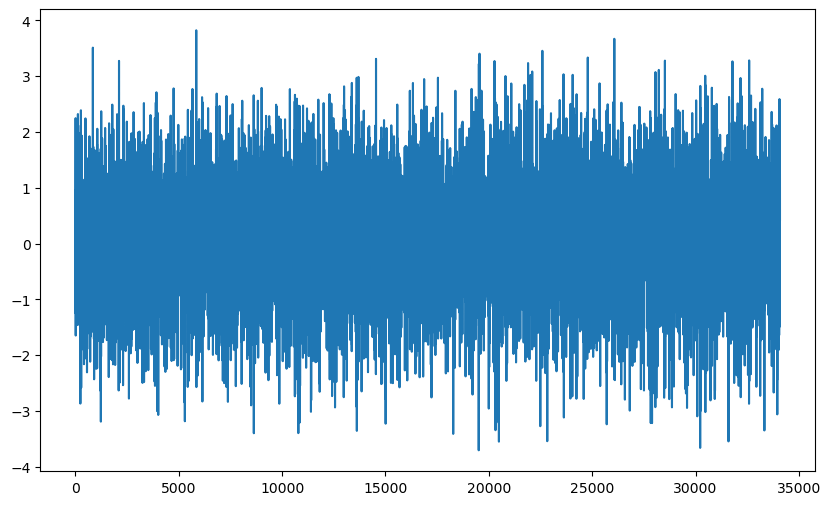

In [35]:
def Jakes_filter(f_max, Ts, N):
    L = N // 2
    n = np.arange(1, L + 1)
    J_pos = sp.jv(0.25, 2 * np.pi * f_max * n * Ts) / (n ** 0.25)
    J_neg = np.flip(J_pos)
    J_0 = 1.468813 * (f_max * Ts) ** 0.25
    J = np.concatenate((J_neg, [J_0], J_pos))

    # Window the filter using Hamming window
    n = np.arange(0, N + 1)
    hamm = 0.54 - 0.46 * np.cos(2 * np.pi * n / N)
    hw = J * hamm

    # Normalized impulse response
    hw = hw / np.sqrt(np.sum(np.abs(hw) ** 2))

    return hw

fd = 10  # maximum Doppler frequency
Fs = 100  # sampling frequency
N = 512  # order of Jakes filter
Ts = 1 / Fs  # sampling interval
h = Jakes_filter(fd, Ts, N)  # design Jakes filter

# Generate the Rayleigh fading envelope
x = np.random.randn(len(packets)+1000)
y = np.convolve(x, h, 'valid')
plt.figure(figsize = (10,6))
plt.plot(y)

In [37]:
print(len(y[:len(packets)]))

33600


Step 3: Add noise and multiply the channel value with the packet notes

In [39]:
def add_awgn_noise(signal, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr / 10))
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

rayleigh_values = y[:len(packets)]

faded_packets = []
for i, packet in enumerate(packets):
    rayleigh_value = rayleigh_values[i]
    faded_packet = packet * rayleigh_value
    faded_packets.append(faded_packet)

snr = 20  # Example SNR value
noisy_packets = [add_awgn_noise(packet, snr) for packet in faded_packets]
print(rayleigh_values.shape)

(33600,)


Step 4: Denoise using Least Squares

In [41]:
def least_squares_denoise(y, A):
    return np.linalg.lstsq(A, y, rcond=None)[0]

denoised_packets = []
for packet in noisy_packets:
    A = np.eye(len(packet))  # Example A matrix, should be based on reference bits
    denoised_packet = least_squares_denoise(packet, A)
    denoised_packets.append(denoised_packet)


Step 5: Predict the next channel value for the incoming packet based on the past window values and then divide the packet by it

In [43]:
history_length = 10  # Window size
X = []
y = []

for i in range(history_length, len(rayleigh_values)):
    X.append(rayleigh_values[i - history_length:i])
    y.append(rayleigh_values[i])

X = np.array(X)
y = np.array(y)
print(len(X))




33590


In [45]:
# Reshape for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(history_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=5, verbose=0)

# Predict the next channel values
predicted_channels = model.predict(X)

# Divide the packets by the predicted channel values
lstm_denoised_packets = []
for i, packet in enumerate(denoised_packets[history_length:]):
    predicted_channel = predicted_channels[i]
    lstm_denoised_packet = packet / predicted_channel
    lstm_denoised_packets.append(lstm_denoised_packet)

C:\Users\vigne\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [47]:
#Step 6 - Play everything
def play_audio(signal, sample_rate):
    audio = np.int16(signal * 32767)
    play_obj = sa.play_buffer(audio, 1, 2, sample_rate)
    play_obj.wait_done()

# Concatenate packets to form the complete signals
original_signal = np.concatenate(packets)
rayleigh_signal = np.concatenate(faded_packets)
noisy_signal = np.concatenate(noisy_packets)
denoised_signal = np.concatenate(denoised_packets)
lstm_denoised_signal = np.concatenate(lstm_denoised_packets)



In [49]:
# Original signal from the transmitter
play_audio(original_signal, sample_rate)

In [51]:
# Signal with the channel effect
play_audio(rayleigh_signal, sample_rate)

In [53]:
# Noisy signal through the channel - which is the raw signal the reciever gets
play_audio(noisy_signal, sample_rate)

In [55]:
# Denoised receiver signal
play_audio(denoised_signal, sample_rate)

In [57]:
#Signal that the receiver decodes after predicting channel using LSTM
play_audio(lstm_denoised_signal, sample_rate)